In [1]:
from collections import defaultdict

import matplotlib.pyplot as pyplot
import numpy as np
import pandas as pd
from scipy.stats import pearsonr
from scipy.cluster import hierarchy

from sklearn.datasets import load_breast_cancer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold


Bad key "text.kerning_factor" on line 4 in
/scratch/ss2686/envs/my-rdkit-env/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


In [2]:
from scipy.io import arff
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import matthews_corrcoef
from scipy.io import arff
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc

In [3]:
cp = pd.read_csv("../../CenterMeanOVLP.csv") 
cp = cp.loc[:,cp.apply(pd.Series.nunique) != 1]
cp



,Unnamed: 0,Cells_AreaShape_Area,Cells_AreaShape_Center_X,Cells_AreaShape_Center_Y,Cells_AreaShape_Compactness,Cells_AreaShape_Eccentricity,Cells_AreaShape_Extent,Cells_AreaShape_FormFactor,Cells_AreaShape_MajorAxisLength,Cells_AreaShape_MaxFeretDiameter,...,Nuclei_Texture_Variance_ER_10_0,Nuclei_Texture_Variance_ER_3_0,Nuclei_Texture_Variance_ER_5_0,Nuclei_Texture_Variance_Mito_10_0,Nuclei_Texture_Variance_Mito_3_0,Nuclei_Texture_Variance_Mito_5_0,Nuclei_Texture_Variance_RNA_10_0,Nuclei_Texture_Variance_RNA_3_0,Nuclei_Texture_Variance_RNA_5_0,smiles_r
0,0,-53.322266,15.138672,-7.832031,0.020546,0.011831,-0.005042,0.006361,1.567715,1.506277,...,0.007785,0.019312,0.020843,-0.064662,-0.072990,-0.084042,0.215716,0.155296,0.176099,Brc1c(NC2=NCCN2)ccc2nccnc12
1,1,41.678711,1.973633,-8.867188,0.008705,0.008857,-0.001514,-0.009787,0.946463,1.437743,...,-0.018887,-0.003844,-0.019000,0.007360,0.025757,0.027188,0.088701,0.052283,0.062916,c1ccc(C(O[C@@H]2CCCN(CCc3ccc4c(c3)OCO4)C2)c2cc...
2,2,418.492188,6.976562,7.766602,0.023997,0.005404,-0.005869,-0.024194,6.252890,6.685650,...,-0.105881,0.011543,0.004370,-0.208441,-0.081369,-0.084740,-0.095445,-0.015152,-0.045636,c1cnc(N2CCN(Cc3ccc4c(c3)OCO4)CC2)nc1
3,3,-10.445312,0.101562,-0.045898,-0.003597,0.000294,0.002599,-0.001359,-0.473211,-0.001053,...,-0.024427,-0.053814,-0.040165,-0.066490,-0.036203,-0.040287,0.040549,0.026975,0.027425,c1ccc(C2CC2)c(OCC2=NCCN2)c1
4,4,48.655273,1.666992,2.486328,0.018529,0.011256,-0.002420,0.004862,1.776159,1.611745,...,0.116695,0.172022,0.164453,-0.012553,0.000800,-0.010659,0.088510,0.083851,0.076598,C(=C/c1ccccc1)\CN1CCN(C(c2ccccc2)c2ccccc2)CC1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
641,641,-133.445312,-2.585938,-4.170898,-0.006187,-0.002578,-0.001801,-0.007760,-2.365016,-2.547309,...,-0.069310,-0.098329,-0.084651,-0.048275,-0.071216,-0.062632,-0.079043,-0.088448,-0.085335,c1ccc2c(c1)[nH]c1cnccc12
642,642,-26.469727,-0.145508,-0.763672,-0.006640,-0.000166,0.001977,-0.003229,-0.770855,-0.478971,...,-0.040332,-0.035610,-0.022689,-0.003744,-0.012261,-0.003150,-0.006708,-0.009239,-0.004748,c1ccc2c(c1)cc1ccc3cccc4ccc2c1c34
643,643,215.939732,2.107143,-7.992188,0.014079,0.009538,-0.005964,0.005382,3.785917,4.371880,...,-0.084987,-0.049924,-0.072038,-0.012332,0.017893,0.006418,0.005525,0.026849,0.029421,c1ccc(-c2ccc(C(c3ccccc3)n3ccnc3)cc2)cc1
644,644,1810.023438,4.320312,-1.496094,0.085425,0.025699,-0.030275,-0.063700,27.234844,31.637251,...,0.243208,0.345452,0.292939,0.108634,0.165323,0.152386,-0.089590,-0.020275,-0.033736,c1cnc2c(c1)ccc1cccnc12


In [7]:
toxcast = pd.read_csv("../../toxcast_Overlap.csv") 

toxcast=toxcast.reindex(columns={'BSK_hDFCGF_Proliferation_down',
             'APR_HepG2_CellLoss_72h_dn',
             'BSK_3C_Proliferation_down',
             'BSK_SAg_Proliferation_down',
             'BSK_3C_SRB_down',
             'BSK_3C_Vis_down',
             'APR_HepG2_CellLoss_24h_dn',
             'BSK_LPS_SRB_down',
             'BSK_CASM3C_Proliferation_down',
             'BSK_SAg_SRB_down',
             'BSK_4H_SRB_down',
             'ACEA_T47D_80hr_Negative','smiles_r' })

toxcast=toxcast.dropna(thresh=(len(toxcast.columns)-11))

toxcast=toxcast.fillna(0)
toxcast['combined_assay']=   toxcast.BSK_SAg_Proliferation_down + toxcast.BSK_LPS_SRB_down + toxcast.ACEA_T47D_80hr_Negative + toxcast.BSK_3C_Vis_down+toxcast.APR_HepG2_CellLoss_24h_dn+toxcast.BSK_CASM3C_Proliferation_down+toxcast.BSK_4H_SRB_down+toxcast.BSK_hDFCGF_Proliferation_down+toxcast.BSK_3C_Proliferation_down+toxcast.APR_HepG2_CellLoss_72h_dn+toxcast.BSK_SAg_SRB_down+toxcast.BSK_3C_SRB_down

toxcast=toxcast[['combined_assay', 'smiles_r']]

toxcast['combined_assay']=toxcast['combined_assay']/12

toxcast['combined_assay']=toxcast['combined_assay'].apply(np.ceil)

tox_list=['combined_assay']

our_data=toxcast.reindex(columns=tox_list)
our_data

,combined_assay
9,1.0
12,0.0
15,1.0
16,1.0
19,1.0
...,...
629,1.0
633,0.0
637,1.0
640,1.0


In [8]:
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.DataStructs import cDataStructs
import seaborn as sns
import matplotlib.pyplot as plt
import rdkit.Chem.Descriptors
from rdkit import Chem
from rdkit.Chem.EState import Fingerprinter
from rdkit.Chem import Descriptors
from rdkit.Chem.rdmolops import RDKFingerprint
from rdkit.Chem.rdMolDescriptors import *
from rdkit.Chem.EState.Fingerprinter import FingerprintMol
from rdkit.Avalon.pyAvalonTools import GetAvalonFP #GetAvalonCountFP  #int vector version
from rdkit.Chem.AllChem import  GetMorganFingerprintAsBitVect, GetErGFingerprint
from rdkit.DataStructs.cDataStructs import ConvertToNumpyArray
import rdkit.DataStructs.cDataStructs
from rdkit.Avalon.pyAvalonTools import GetAvalonFP

def MorganFingerprint(s):
    x = Chem.MolFromSmiles(s)
    return (AllChem.GetMorganFingerprintAsBitVect(x,2,2048))



In [9]:
from sklearn.feature_selection import VarianceThreshold



In [10]:
#importing libraries
from sklearn.datasets import load_boston
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.linear_model import RidgeCV, LassoCV, Ridge, Lasso

In [11]:
from sklearn.feature_selection import VarianceThreshold
from numpy  import array



In [12]:
from scipy import stats
from scipy.stats import ks_2samp 
#Calculates a point biserial correlation coefficient and the associated p-value.

    


In [13]:
from sklearn.preprocessing import LabelBinarizer # one hot encoding
from sklearn.preprocessing import PolynomialFeatures # add polynomial features
from sklearn.linear_model import LogisticRegression
import seaborn as sns
 #Grid Search with Cross Validation RF
from sklearn import metrics


from sklearn.model_selection import GridSearchCV
# Create the parameter grid based on the results of random search

In [14]:
from sklearn import datasets, metrics, model_selection, svm
from sklearn import svm, datasets
from sklearn.metrics import auc
from sklearn.metrics import plot_roc_curve

In [15]:
from sklearn import datasets, metrics, model_selection, svm
from sklearn import svm, datasets
from sklearn.metrics import auc
from sklearn.metrics import plot_roc_curve
import matplotlib.pyplot as plt
from matplotlib import gridspec

from rdkit import Chem, DataStructs
from rdkit.Chem import Descriptors,Crippen

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

import matplotlib.cm as cm
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.cluster import KMeans
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.model_selection import GroupKFold

In [16]:
def GetExactMolWt(s):
    mol = Chem.MolFromSmiles(s)
    return (Descriptors.ExactMolWt (mol))
def GetCalcTPSA(s):
    mol = Chem.MolFromSmiles(s)
    return (Chem.rdMolDescriptors.CalcTPSA(mol))
def GetNumRotatableBonds(s):
    mol = Chem.MolFromSmiles(s)
    return (Descriptors.NumRotatableBonds (mol))
def GetNumHDonors(s):
    mol = Chem.MolFromSmiles(s)
    return (Descriptors.NumHDonors(mol))
def GetNumHAcceptors(s):
    mol = Chem.MolFromSmiles(s)
    return (Descriptors.NumHAcceptors(mol) )
def GetMolLogP(s):
    mol = Chem.MolFromSmiles(s)
    return (Descriptors.MolLogP(mol))

Start
1.0    86
0.0    49
Name: combined_assay, dtype: int64


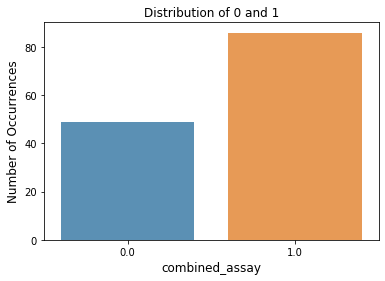

Total Compounds in Assay:  135
pca explained variance by first two components:  0.7280338488123717


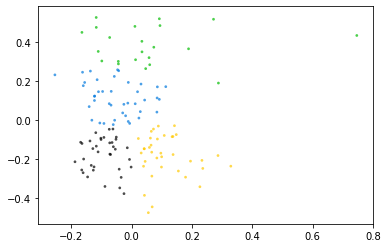

Start
1    41
3    36
0    36
2    22
Name: Cluster_PC1_PC2, dtype: int64


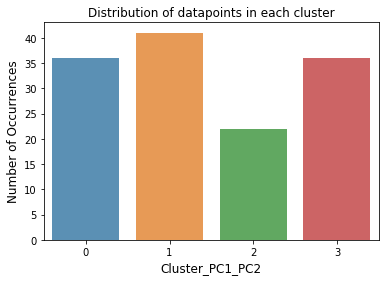

Total Selected train:  94
Total Selected test:  41
Fitting 5 folds for each of 768 candidates, totalling 3840 fits


[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done  82 tasks      | elapsed:    7.8s
[Parallel(n_jobs=40)]: Done 285 tasks      | elapsed:   22.6s
[Parallel(n_jobs=40)]: Done 568 tasks      | elapsed:   48.1s
[Parallel(n_jobs=40)]: Done 933 tasks      | elapsed:  1.4min
[Parallel(n_jobs=40)]: Done 1378 tasks      | elapsed:  2.2min
[Parallel(n_jobs=40)]: Done 1905 tasks      | elapsed:  3.1min
[Parallel(n_jobs=40)]: Done 2512 tasks      | elapsed:  4.2min
[Parallel(n_jobs=40)]: Done 3201 tasks      | elapsed:  5.4min
[Parallel(n_jobs=40)]: Done 3840 out of 3840 | elapsed:  6.2min finished


Tuned Mode:  RandomForestClassifier(bootstrap=False, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=15, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=15, min_samples_split=6,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=-1, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)
In this fold
conf_matrix: 
  [[ 5  2]
 [15 19]]
classification_report: 
               precision    recall  f1-score   support

         0.0       0.25      0.71      0.37         7
         1.0       0.90      0.56      0.69        34

    accuracy                           0.59        41
   macro avg       0.58      0.64      0.53        41
weighted avg       0.79      0.59      0.64        41

Total Selected train:  99
Total Selecte

[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done  82 tasks      | elapsed:    9.8s
[Parallel(n_jobs=40)]: Done 285 tasks      | elapsed:   29.4s
[Parallel(n_jobs=40)]: Done 568 tasks      | elapsed:   57.1s
[Parallel(n_jobs=40)]: Done 933 tasks      | elapsed:  1.6min
[Parallel(n_jobs=40)]: Done 1378 tasks      | elapsed:  2.3min
[Parallel(n_jobs=40)]: Done 1905 tasks      | elapsed:  3.3min
[Parallel(n_jobs=40)]: Done 2512 tasks      | elapsed:  4.3min
[Parallel(n_jobs=40)]: Done 3201 tasks      | elapsed:  5.3min
[Parallel(n_jobs=40)]: Done 3840 out of 3840 | elapsed:  6.3min finished


Tuned Mode:  RandomForestClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=15, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=3, min_samples_split=6,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)
In this fold
conf_matrix: 
  [[ 0 25]
 [ 0 11]]
classification_report: 
               precision    recall  f1-score   support

         0.0       0.00      0.00      0.00        25
         1.0       0.31      1.00      0.47        11

    accuracy                           0.31        36
   macro avg       0.15      0.50      0.23        36
weighted avg       0.09      0.31      0.14        36



/scratch/ss2686/envs/my-rdkit-env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/scratch/ss2686/envs/my-rdkit-env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:900: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


Total Selected train:  99
Total Selected test:  36
Fitting 5 folds for each of 768 candidates, totalling 3840 fits


[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done  82 tasks      | elapsed:   10.4s
[Parallel(n_jobs=40)]: Done 285 tasks      | elapsed:   31.0s
[Parallel(n_jobs=40)]: Done 568 tasks      | elapsed:   59.5s
[Parallel(n_jobs=40)]: Done 933 tasks      | elapsed:  1.6min
[Parallel(n_jobs=40)]: Done 1378 tasks      | elapsed:  2.4min
[Parallel(n_jobs=40)]: Done 1905 tasks      | elapsed:  3.3min
[Parallel(n_jobs=40)]: Done 2512 tasks      | elapsed:  4.3min
[Parallel(n_jobs=40)]: Done 3201 tasks      | elapsed:  5.2min
[Parallel(n_jobs=40)]: Done 3840 out of 3840 | elapsed:  6.2min finished


Tuned Mode:  RandomForestClassifier(bootstrap=False, ccp_alpha=0.0, class_weight='balanced',
                       criterion='entropy', max_depth=15, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=3, min_samples_split=12,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)
In this fold
conf_matrix: 
  [[12  3]
 [15  6]]
classification_report: 
               precision    recall  f1-score   support

         0.0       0.44      0.80      0.57        15
         1.0       0.67      0.29      0.40        21

    accuracy                           0.50        36
   macro avg       0.56      0.54      0.49        36
weighted avg       0.57      0.50      0.47        36

Total Selected train:  113
Total Sel

[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done  82 tasks      | elapsed:   10.1s
[Parallel(n_jobs=40)]: Done 285 tasks      | elapsed:   30.9s
[Parallel(n_jobs=40)]: Done 568 tasks      | elapsed:  1.0min
[Parallel(n_jobs=40)]: Done 933 tasks      | elapsed:  1.6min
[Parallel(n_jobs=40)]: Done 1378 tasks      | elapsed:  2.4min
[Parallel(n_jobs=40)]: Done 1905 tasks      | elapsed:  3.3min
[Parallel(n_jobs=40)]: Done 2512 tasks      | elapsed:  4.1min
[Parallel(n_jobs=40)]: Done 3201 tasks      | elapsed:  4.8min
[Parallel(n_jobs=40)]: Done 3840 out of 3840 | elapsed:  5.4min finished


Tuned Mode:  RandomForestClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=15, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=3, min_samples_split=9,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=-1, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)
In this fold
conf_matrix: 
  [[ 0  2]
 [ 2 18]]
classification_report: 
               precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         2
         1.0       0.90      0.90      0.90        20

    accuracy                           0.82        22
   macro avg       0.45      0.45      0.45        22
weighted avg       0.82      0.82      0.82        22



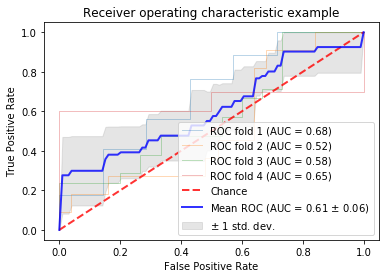

Mean of Each fold


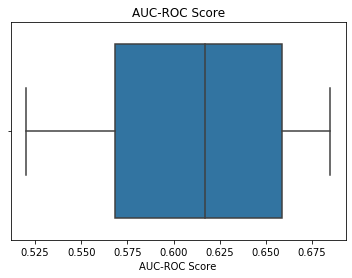

AUC-ROC all:  [0.6848739495798319, 0.52, 0.584126984126984, 0.6499999999999999]
AUC-ROC = 0.61 ± 0.06)


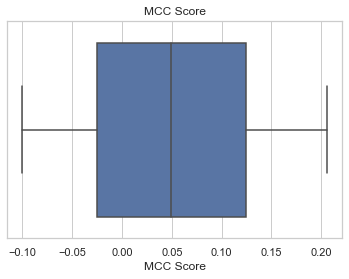

Matthews_corrcoef all:  [0.20558916985752212, 0.0, 0.09759000729485331, -0.1]
Matthews_corrcoef = 0.051 ± 0.113)


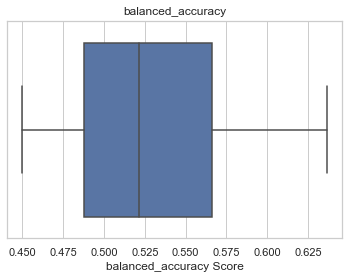

balanced_accuracy all:  [0.6365546218487395, 0.5, 0.5428571428571429, 0.45]
balanced_accuracy = 0.53 ± 0.07)


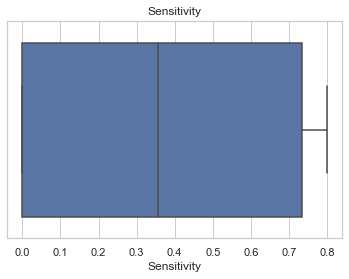

Sensitivity all:  [0.7142857142857143, 0.0, 0.8, 0.0]
Sensitivity = 0.38 ± 0.38)


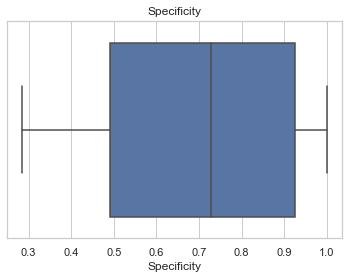

Specificity all:  [0.5588235294117647, 1.0, 0.2857142857142857, 0.9]
Specificity = 0.69 ± 0.28)
One Combined Confusion Matrix
conf_matrix: 
  [[17 32]
 [32 54]]
classification_report: 
               precision    recall  f1-score   support

         0.0       0.35      0.35      0.35        49
         1.0       0.63      0.63      0.63        86

    accuracy                           0.53       135
   macro avg       0.49      0.49      0.49       135
weighted avg       0.53      0.53      0.53       135

matthews_corrcoef
-0.025154247745609874
balanced_accuracy_score
0.48742287612719504
Sensitivity
0.3469387755102041
Specificity
0.627906976744186
AUC-ROC for the combined results: 


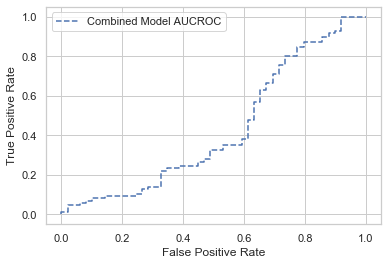

Combined Model AUC ROC:  0.42928334124347417
['{0.051 ± 0.113)}']


In [20]:
list_of_lists = []

for col in tox_list:
    
    print("Start")
    toxcast_counts=our_data[col].value_counts()
    print(our_data[col].value_counts())
    pyplot.figure()
    sns.barplot(toxcast_counts.index, toxcast_counts.values, alpha=0.8)
    pyplot.title('Distribution of 0 and 1')
    pyplot.ylabel('Number of Occurrences', fontsize=12)
    pyplot.xlabel(col, fontsize=12)
    pyplot.show()
    
    method = "Morgan_2048"
    
    n_cluster=4 
        
    target=col
    
    
    df_temp=pd.merge(cp, toxcast[[target, 'smiles_r']], left_on = 'smiles_r', right_on = 'smiles_r', how = 'inner')
    df_temp['MorganFingerprint'] =df_temp['smiles_r'].apply(MorganFingerprint)
    df_temp=df_temp.dropna(subset=[target])
    df_temp=df_temp.drop('Unnamed: 0', axis = 1)

    X = np.array([x for x in df_temp['MorganFingerprint']])
    
    df_temp=df_temp.drop('MorganFingerprint', axis = 1)
    data=df_temp
    
    data=data.drop('smiles_r', axis = 1)
    y = data[target]

    y=y.to_numpy()
    
    print("Total Compounds in Assay: ", len(X))
    #PCA to groups
    
    df_temp['MolWt']=df_temp['smiles_r'].apply(GetExactMolWt)
    df_temp['TPSA']=df_temp['smiles_r'].apply(GetCalcTPSA) #Topological Polar Surface Area
    df_temp['nRotB']=df_temp['smiles_r'].apply(GetNumRotatableBonds) #Number of rotable bonds
    df_temp['HBD']=df_temp['smiles_r'].apply(GetNumHDonors) #Number of H bond donors
    df_temp['HBA']=df_temp['smiles_r'].apply(GetNumHAcceptors) #Number of H bond acceptors
    df_temp['LogP']=df_temp['smiles_r'].apply(GetMolLogP) #LogP

    descriptors = df_temp.loc[:, ['MolWt', 'TPSA', 'nRotB', 'HBD','HBA', 'LogP']].values
    descriptors_std = StandardScaler().fit_transform(descriptors)
    
    pca = PCA()
    descriptors_2d = pca.fit_transform(descriptors_std)
    descriptors_pca= pd.DataFrame(descriptors_2d)
    descriptors_pca.index = df_temp.index
    descriptors_pca.columns = ['PC{}'.format(i+1) for i in descriptors_pca.columns]

    print("pca explained variance by first two components: ", (pca.explained_variance_ratio_[0]+ pca.explained_variance_ratio_[1]))

    # This normalization will be performed just for PC1 and PC2, but can be done for all the components.
    scale1 = 1.0/(max(descriptors_pca['PC1']) - min(descriptors_pca['PC1']))
    scale2 = 1.0/(max(descriptors_pca['PC2']) - min(descriptors_pca['PC2']))

    # And we add the new values to our PCA table
    descriptors_pca['PC1_normalized']=[i*scale1 for i in descriptors_pca['PC1']]
    descriptors_pca['PC2_normalized']=[i*scale2 for i in descriptors_pca['PC2']]

    kmeans = KMeans(n_clusters=n_cluster, random_state=0)
    cluster_labels = kmeans.fit_predict(descriptors_pca[['PC1_normalized','PC2_normalized']])
    
  
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_cluster)
    plt.scatter(descriptors_pca['PC1_normalized'], descriptors_pca['PC2_normalized'], marker='.', s=30, lw=0, alpha=0.7,c=colors, edgecolor='k')
    plt.show()
    
    
    df_temp['Cluster_PC1_PC2'] = pd.Series(kmeans.labels_, index=df_temp.index)
    print("Start")
    cluster_counts=df_temp['Cluster_PC1_PC2'].value_counts()
    print(df_temp['Cluster_PC1_PC2'].value_counts())
    plt.figure()
    sns.barplot(cluster_counts.index, cluster_counts.values, alpha=0.8)
    plt.title('Distribution of datapoints in each cluster')
    plt.ylabel('Number of Occurrences', fontsize=12)
    plt.xlabel('Cluster_PC1_PC2', fontsize=12)
    plt.show()
    
    
    outercv = GroupKFold(n_splits=n_cluster)
    outercv.get_n_splits(X, y, kmeans.labels_)
    
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)

    fig, ax = plt.subplots()
    
    mat_cof=[]
    ba=[]
    sen=[]
    spe=[]
    combined_y_test=[]
    combined_y_pred=[]
    
    for i, (train_index, test_index) in enumerate(outercv.split(X, y, kmeans.labels_)):
        
        
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        print("Total Selected train: ",  len(X_train))
        print("Total Selected test: ",  len(X_test))
        
        inner_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
           
        param_grid = { 
        'max_depth': [15, 10, 20],
        'max_features': ['auto'],
        'min_samples_leaf': [3, 6, 12, 15],
        'min_samples_split': [6, 9, 12, 15],
        'n_estimators':[100, 200, 300, 700],
        'bootstrap': [False],
        'oob_score': [False],
        'random_state': [0],
        'criterion': ['gini', 'entropy'],
        'n_jobs': [-1],
        'class_weight' : [None, 'balanced']
        }
        

       # Create a based model
        rf = RandomForestClassifier()
        # Instantiate the grid search model
        grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                                  cv = inner_cv, n_jobs = 40, verbose = 2)

        # Fit the grid search to the data
        grid_search.fit(X_train, y_train)
        print("Tuned Mode: ", grid_search.best_estimator_)

        classifier = grid_search.best_estimator_
        
        classifier.fit(X_train, y_train)
        
        y_pred = classifier.predict(X_test)
        y_proba = classifier.predict_proba(X_test)
       
        combined_y_test=np.concatenate((combined_y_test, y_test), axis=None)
        combined_y_pred=np.concatenate((combined_y_pred, y_pred), axis=None)
        
        if i==0:
            combined_y_proba=y_proba
        else:
            combined_y_proba=np.concatenate((combined_y_proba, y_proba), axis=0)
    
    
        conf_matrix = confusion_matrix(y_test, y_pred)
        print("In this fold")
        print("conf_matrix: \n " , conf_matrix)
        print("classification_report: \n",classification_report(y_test, y_pred))
    
        mat_cof.append(matthews_corrcoef(y_test, y_pred))
        ba.append(balanced_accuracy_score(y_test, y_pred))
        
        sen.append(conf_matrix[0,0]/(conf_matrix[0,0]+conf_matrix[0,1]))
        spe.append(conf_matrix[1,1]/(conf_matrix[1,0]+conf_matrix[1,1]))

        
        viz = plot_roc_curve(classifier, X_test, y_test,
                             name='ROC fold {}'.format(1+i),
                             alpha=0.3, lw=1, ax=ax)
        
        interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        aucs.append(viz.roc_auc)

    ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
            label='Chance', alpha=.8)

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    ax.plot(mean_fpr, mean_tpr, color='b',
            label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
            lw=2, alpha=.8)

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                    label=r'$\pm$ 1 std. dev.')

    ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
           title="Receiver operating characteristic example")
    ax.legend(loc="lower right")
    plt.show()
    
    print("Mean of Each fold")
    
    sns.boxplot(x=aucs).set(title = 'AUC-ROC Score', xlabel = 'AUC-ROC Score' )
    plt.show()
    print("AUC-ROC all: ",(aucs))
    print(r"AUC-ROC = %0.2f ± %0.2f)" % (np.mean(aucs), np.std(aucs)))
    row=[col, method, 'AUC-ROC'] + aucs
    list_of_lists.append(row)
    sns.set(style="whitegrid")    
       
    sns.boxplot(x=mat_cof).set(title = 'MCC Score', xlabel = 'MCC Score' )
    plt.show()
    print("Matthews_corrcoef all: ",(mat_cof))
    print(r"Matthews_corrcoef = %0.3f ± %0.3f)" % (np.mean(mat_cof), np.std(mat_cof)))
    row=[col, method, 'MCC'] + mat_cof
    list_of_lists.append(row)
    
    sns.boxplot(x=ba).set(title = 'balanced_accuracy', xlabel = 'balanced_accuracy Score' )
    plt.show() 
    print("balanced_accuracy all: ",(ba))
    print(r"balanced_accuracy = %0.2f ± %0.2f)" % (np.mean(ba), np.std(ba)))
    row=[col, method, 'BA'] + ba
    list_of_lists.append(row)
    
    
    sns.boxplot(x=sen).set(title = 'Sensitivity', xlabel = 'Sensitivity' )
    plt.show()
    print("Sensitivity all: ",(sen))
    print(r"Sensitivity = %0.2f ± %0.2f)" % (np.mean(sen), np.std(sen)))
    row=[col, method, 'SEN'] + sen
    list_of_lists.append(row)
    
    
    sns.boxplot(x=spe).set(title = 'Specificity', xlabel = 'Specificity' )
    plt.show()
    print("Specificity all: ",(spe))
    print(r"Specificity = %0.2f ± %0.2f)" % (np.mean(spe), np.std(spe)))
    row=[col, method, 'SPE'] + spe
    list_of_lists.append(row)
    
    
    print("One Combined Confusion Matrix")
    combined_conf_matrix = confusion_matrix(combined_y_test, combined_y_pred)
    print("conf_matrix: \n " , combined_conf_matrix)
    print("classification_report: \n",classification_report(combined_y_test, combined_y_pred))
    
    print('matthews_corrcoef')
    print(matthews_corrcoef(combined_y_test, combined_y_pred))
    
    print('balanced_accuracy_score')
    print(balanced_accuracy_score(combined_y_test, combined_y_pred))
    
    print('Sensitivity')   
    print(combined_conf_matrix[0,0]/(combined_conf_matrix[0,0]+combined_conf_matrix[0,1]))
    
    print('Specificity')  
    print(combined_conf_matrix[1,1]/(combined_conf_matrix[1,0]+combined_conf_matrix[1,1]))
       
    print("AUC-ROC for the combined results: ")
    
    probs_combined_model= combined_y_proba[:,1]
    roc_value_combined_model= roc_auc_score(combined_y_test, probs_combined_model) 
    base_model_fpr, base_model_tpr, _ = roc_curve(combined_y_test, probs_combined_model)
    plt.plot(base_model_fpr, base_model_tpr, linestyle='--', label='Combined Model AUCROC')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    # show the legend
    plt.legend()
    # show the plot
    plt.show()
    print("Combined Model AUC ROC: ", roc_value_combined_model)
    
    row= ["{%0.3f ± %0.3f)}" % (np.mean(mat_cof), np.std(mat_cof))
         ]
    print(row)

In [22]:
df=pd.DataFrame(list_of_lists,columns=["target", "method", "metric", "1", "2", "3", "4"])
df['mean']=df.drop(['target', 'method', 'metric'], axis=1).apply(lambda x: x.mean(), axis=1)
df['std']=df.drop(['target', 'method','metric'], axis=1).apply(lambda x: x.std(), axis=1)
df['value']= df['mean'].round(2).astype(str) + " ± " + df['std'].round(2).astype(str)

In [23]:
df

,target,method,metric,1,2,3,4,mean,std,value
0,combined_assay,Morgan_2048,AUC-ROC,0.684874,0.52,0.584127,0.65,0.609750,0.063197,0.61 ± 0.06
1,combined_assay,Morgan_2048,MCC,0.205589,0.00,0.097590,-0.10,0.050795,0.113435,0.05 ± 0.11
2,combined_assay,Morgan_2048,BA,0.636555,0.50,0.542857,0.45,0.532353,0.068551,0.53 ± 0.07
3,combined_assay,Morgan_2048,SEN,0.714286,0.00,0.800000,0.00,0.378571,0.379782,0.38 ± 0.38
4,combined_assay,Morgan_2048,SPE,0.558824,1.00,0.285714,0.90,0.686134,0.283194,0.69 ± 0.28


In [24]:
file_name="Metrics_"+method+".csv"
df.to_csv(file_name)